In [26]:
import os
import sys
import random
import math
import numpy as np
import skimage.io
import matplotlib
import matplotlib.pyplot as plt

# Root directory of the project
ROOT_DIR = "C:/Users/dpawa/PycharmProjects/daen690/Mask_RCNN/"

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

# Import COCO config
sys.path.append(os.path.join(ROOT_DIR, "samples/"))  # To find local version
import coco

%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "samples/coco_new.h5")
# Download COCO trained weights from Releases if needed

# Directory of images to run detection on
#IMAGE_DIR = os.path.join(ROOT_DIR, "image")
#OutIMAGE_DIR = "/home/ashwin/Desktop/Test/jupyter_output"


In [27]:


class InferenceConfig(coco.CocoConfig):
    IMAGES_PER_GPU = 1
    GPU_COUNT = 1
    MEAN_PIXEL = [123.7,116.8,103.9]
    RPN_ANCHOR_SCALES = (8, 16, 32, 64, 128)
    DETECTION_MIN_CONFIDENCE = 0.5

config = InferenceConfig()


In [18]:
config.display()



Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.5
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                17
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

In [28]:
class_names = ['BG','no-damage','minor-damage','major-damage','destroyed']

# Create model object in inference mode.
model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR, config=config)



In [29]:
# Load weights trained on MS-COCO
model.load_weights(COCO_MODEL_PATH, by_name=True)

In [30]:
dataset_val = coco.CocoDataset()
val_type = "val" 
dataset_path = "C:\\Users\\dpawa\\PycharmProjects\\daen690\\Mask_RCNN\\samples\\test_pre_post_quad"
dataset_val.load_coco(dataset_path, val_type, year="2019")
dataset_val.prepare()

loading annotations into memory...
Done (t=0.04s)
creating index...
index created!


original_image           shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
image_meta               shape: (17,)                 min:    0.00000  max: 1024.00000  int32
gt_class_id              shape: (190,)                min:    1.00000  max:    4.00000  int32
gt_bbox                  shape: (190, 4)              min:    0.00000  max: 1023.00000  int32
gt_mask                  shape: (1024, 1024, 190)     min:    0.00000  max:    1.00000  bool


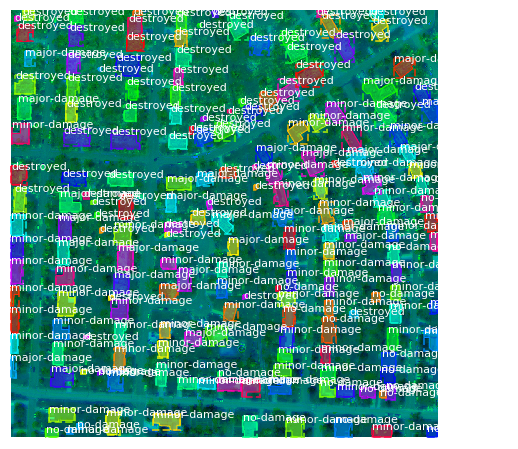

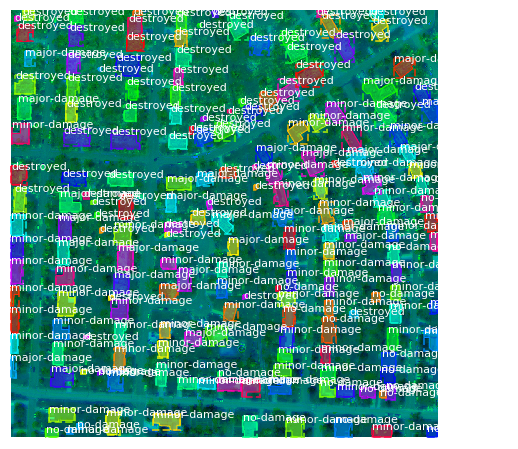

In [50]:
# Test on a random image
image_id = random.choice(dataset_val.image_ids)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_val, config, 
                           image_id, use_mini_mask=False)

log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, class_names, figsize=(8, 8))

In [20]:
print(gt_class_id)

[4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 2 2 2 2 4 4 4 4 2 2 2 3 4 4 4 4 4 4 4 4 3 4 4 3 4 4 3 4 4 4 4 3 3 3 3
 3 3 3 4 4 4 2 2 3 3 2 2 2 4 3 4 4 3 3 4 3 2 2 2 3 4 4 4 4 4 4 2 2 3 3 3 3
 3 3 3 2 2 2 2 2 2 1 2 1 1 2 2 2 2 2 2 2 3 3 2 1 2 2 1 2 2 2 2 2 2 2 2 4 4
 4 4 2 4 4 4 4 4 4 4 4 4 4 4 4 1 4 4 4 4 4 4 4 4 4 4 4 4 4 4]


In [51]:
def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax
results = model.detect([original_image], verbose=0)



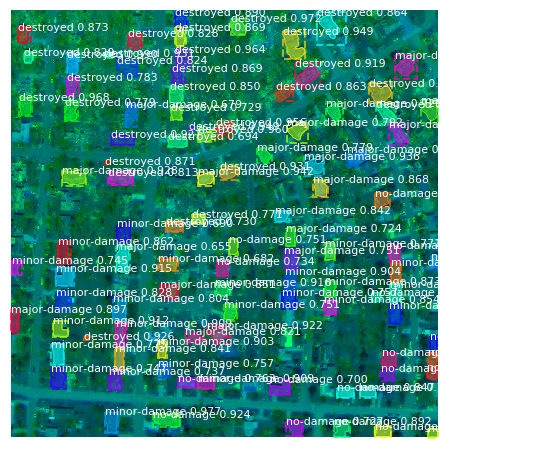

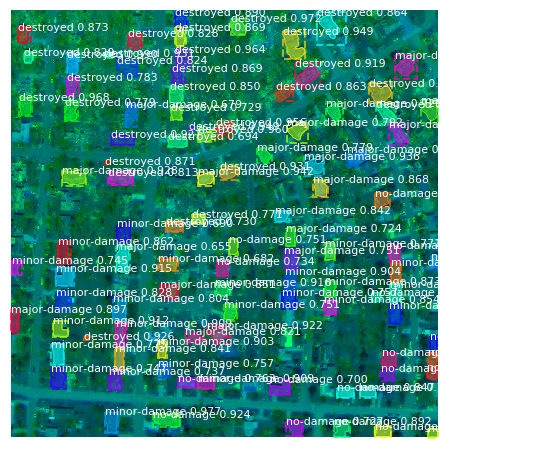

In [52]:
r = results[0]
visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_val.class_names, r['scores'], figsize=(8, 8))

In [15]:
#val_images = os.listdir(os.path.join(dataset_path,"valimages"))


In [53]:
#image_ids = np.random.choice(dataset_val.image_ids)
APs = []
f1s = []


# Load image and ground truth data
image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_val, config,
                           image_id, use_mini_mask=False)
molded_images = np.expand_dims(modellib.mold_image(image, config), 0)
# Run object detection
results = model.detect([image], verbose=0)
r = results[0]
# Compute AP
AP, precisions, recalls, overlaps =\
    utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                     r["rois"], r["class_ids"], r["scores"], r['masks'])
APs.append(AP)

f1 = utils.compute_f1_space(gt_bbox, gt_class_id, gt_mask,r["rois"], r["class_ids"], r["scores"], r['masks'])
f1s.append(f1)


print("mAP @ IoU=50:: ", np.mean(APs))
print("F1: ", np.mean(f1s))

mAP @ IoU=50::  0.27448661628544857
F1:  0.45517241379310347


In [25]:
def compute_batch_ap(image_ids):
    APs = []
    for image_id in image_ids:
        # Load image
        image, image_meta, gt_class_id, gt_bbox, gt_mask =\
            modellib.load_image_gt(dataset_val, config,
                                   image_id, use_mini_mask=False)
        # Run object detection
        results = model.detect([image], verbose=0)
        # Compute AP
        r = results[0]
        AP, precisions, recalls, overlaps =\
            utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                              r['rois'], r['class_ids'], r['scores'], r['masks'])
        APs.append(AP)
    return APs

# Pick a set of random images
image_ids = np.random.choice(dataset_val.image_ids, 10)
APs = compute_batch_ap(image_ids)
print("mAP @ IoU=50: ", np.mean(APs))

mAP @ IoU=50:  0.34557891932285856


In [24]:
print("Number of detected buildings =",len(r['rois']))

Number of detected buildings = 100


In [26]:
print(gt_class_id)

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


In [8]:
activations = model.run_graph([original_image], [
    ("input_image",        model.keras_model.get_layer("input_image").output),
    ("res2c_out",          model.keras_model.get_layer("res2c_out").output),
    ("res3c_out",          model.keras_model.get_layer("res3c_out").output),
    ("res4w_out",          model.keras_model.get_layer("res4w_out").output),  # for resnet100
    ("rpn_bbox",           model.keras_model.get_layer("rpn_bbox").output),
    ("roi",                model.keras_model.get_layer("ROI").output),
])

input_image              shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10001  float32
res2c_out                shape: (1, 256, 256, 256)    min:    0.00000  max:   52.34834  float32
res3c_out                shape: (1, 128, 128, 512)    min:    0.00000  max:   34.58058  float32
res4w_out                shape: (1, 64, 64, 1024)     min:    0.00000  max:   49.26321  float32
rpn_bbox                 shape: (1, 261888, 4)        min:  -17.56482  max:   54.11993  float32
roi                      shape: (1, 1000, 4)          min:    0.00000  max:    1.00000  float32


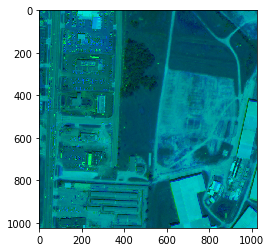

In [13]:
_ = plt.imshow(modellib.unmold_image(activations["input_image"][0],config))


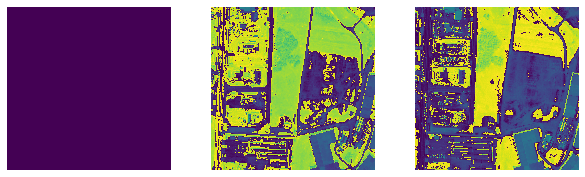

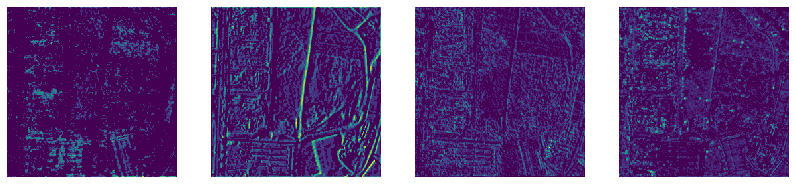

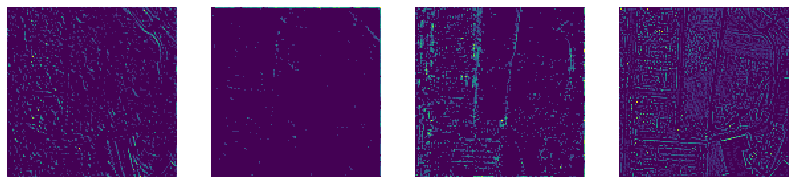

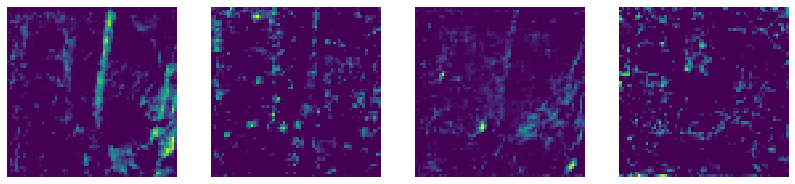

In [12]:
from mrcnn.visualize import display_images

# Backbone feature map
display_images(np.transpose(activations["input_image"][0,:,:,:4], [2, 0, 1]), cols=4)
display_images(np.transpose(activations["res2c_out"][0,:,:,:4], [2, 0, 1]), cols=4)
display_images(np.transpose(activations["res3c_out"][0,:,:,:4], [2, 0, 1]), cols=4)
display_images(np.transpose(activations["res4w_out"][0,:,:,:4], [2, 0, 1]), cols=4)